In [143]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [144]:
BONUS_THRESH = 4_000

START_BALANCE = 10896.91

FINAL_MONTH, FINAL_DAY = 7, 30
LAST_YEAR = 2024

In [145]:
credit_dfs = [pd.read_csv(f"data/chase/{path}") for path in os.listdir("data/chase/") if path.startswith("Chase3098")]
credit_df = pd.concat(credit_dfs).reset_index()
credit_df = credit_df.drop("Transaction Date", axis="columns")
credit_df = credit_df.rename({"Post Date": "Posting Date"}, axis="columns")
credit_df["Posting Date"] = pd.to_datetime(credit_df["Posting Date"])

checking_df = pd.read_csv("data\chase\Chase7113_Activity_20240710.CSV", index_col=False)
checking_df = checking_df[checking_df["Type"] != "MISC_DEBIT"]
checking_df["Balance"] = checking_df.Balance.astype(np.float64)
checking_df["Posting Date"] = pd.to_datetime(checking_df["Posting Date"])
checking_df = checking_df.sort_values("Posting Date")

# Start from Sept 2022 (first stable post-moving month)
credit_df = credit_df[credit_df["Posting Date"] >= datetime.datetime(day=1, month=9, year=2022)]
checking_df = checking_df[checking_df["Posting Date"] >= datetime.datetime(day=1, month=9, year=2022)]

# End at last month
credit_df = credit_df[credit_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=LAST_YEAR)]
checking_df = checking_df[
    checking_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=LAST_YEAR)
]

# Add month col for grouping
credit_df["month"] = pd.to_datetime(
    credit_df["Posting Date"].dt.year.astype(str) + "-" + credit_df["Posting Date"].dt.month.astype(str)
)
checking_df["month"] = pd.to_datetime(
    checking_df["Posting Date"].dt.year.astype(str) + "-" + checking_df["Posting Date"].dt.month.astype(str)
)

### 1. Prep debit expenses table

In [146]:
debit_df = checking_df[checking_df.Amount < 0]

# ignore credit card payments, since they double count cc expenses
cc_pay_keywords = ["Payment to Chase card", "CHASE CREDIT CRD"]
debit_df = debit_df[~pd.DataFrame([debit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 2. Prep credit expenses table

In [147]:
# drop cc payments
cc_pay_keywords = ["Returned Payment", "Payment Thank You", "AUTOMATIC PAYMENT - THANK"]
credit_df = credit_df[~pd.DataFrame([credit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 3. Prep income table

In [148]:
credit_df[credit_df.Amount > 0]

,index,Posting Date,Description,Category,Type,Amount,Memo,month
77,77,2022-11-22,UNITED 0162447982370,Travel,Return,170.00,NaN,2022-11-01
221,51,2023-12-05,Ralph Lauren Corporation,Shopping,Return,72.00,NaN,2023-12-01
271,101,2023-11-15,USTA.COM,Entertainment,Return,28.45,NaN,2023-11-01
308,138,2023-10-22,Zipcar Trip OCT21,Travel,Return,37.72,NaN,2023-10-01
315,145,2023-10-22,Zipcar Trip OCT21,Travel,Return,10.62,NaN,2023-10-01
330,160,2023-10-15,JETBLUE 2790499942499,Travel,Return,213.90,NaN,2023-10-01
437,267,2023-09-22,7462-RailNinja,Travel,Return,306.00,NaN,2023-09-01
498,328,2023-09-06,7462-RailNinja,Travel,Return,360.00,NaN,2023-09-01
541,371,2023-08-27,AMTRAK .COM 2320641598040,Travel,Return,51.00,NaN,2023-08-01
583,413,2023-08-09,AIRBNB * HMC3BSE2KD,Travel,Return,176.92,NaN,2023-08-01


In [149]:
refund_df

,Details,Posting Date,Description,Amount,Type,Balance,Check or Slip #,month
547,DEBIT,2022-09-30,TOTAL WINE AND MORE 17 EVERETT MA 0...,27.96,DEBIT_CARD,4678.95,NaN,2022-09-01
546,DEBIT,2022-09-30,TOTAL WINE AND MORE 17 EVERETT MA 0...,4.99,DEBIT_CARD,4683.94,NaN,2022-09-01
545,DEBIT,2022-09-30,TOTAL WINE AND MORE 17 EVERETT MA 0...,2.80,DEBIT_CARD,4686.74,NaN,2022-09-01
503,CREDIT,2022-10-18,STUBHUB CONS PAYMENTS PP...,180.00,ACH_CREDIT,5576.14,NaN,2022-10-01
500,CREDIT,2022-10-20,STUBHUB CONS PAYMENTS PP...,405.00,ACH_CREDIT,5945.16,NaN,2022-10-01
491,DEBIT,2022-10-27,TARGET.COM * 800-591-3869 MN 1...,0.11,DEBIT_CARD,5773.10,NaN,2022-10-01
472,CREDIT,2022-11-04,Zelle payment from BRIAN GLAZE 15713313991,900.00,QUICKPAY_CREDIT,9248.41,NaN,2022-11-01
471,CREDIT,2022-11-07,VENMO CASHOUT PP...,1163.67,ACH_CREDIT,10412.08,NaN,2022-11-01
465,CREDIT,2022-11-14,VENMO CASHOUT PP...,248.29,ACH_CREDIT,5977.02,NaN,2022-11-01
451,CREDIT,2022-12-08,Zelle payment from JIA HE BACcp3gl59wc,69.00,PARTNERFI_TO_CHASE,11250.09,NaN,2022-12-01


In [150]:
income_df = checking_df[checking_df.Amount > 0]

# partition out paychecks
paycheck_df = income_df[income_df.Description.str.contains("MICROSOFT")]
income_df = income_df.drop(paycheck_df.index, axis=0)

# separate bonuses from paychecks
bonus_rows = []
for i, (idx, row) in enumerate(paycheck_df.iterrows()):
    if row.Amount > 4_000:
        # get bonus amount by comparing to surrounding paychecks
        if (i + 1 < len(paycheck_df)) and paycheck_df.iloc[i + 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i + 1].Amount
        elif i != 0 and paycheck_df.iloc[i - 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i - 1].Amount
        else:
            raise Exception("no valid paycheck to compare")

        # update paycheck_df
        paycheck_df.loc[idx, "Amount"] -= bonus_amt

        bonus_row = row.copy()
        row.Amount = bonus_amt

        # save bonus row
        bonus_rows.append(row)
bonus_df = pd.DataFrame(bonus_rows)

# partition out stocks (+ other random bonus looking things)
stock_keywords = ["SCHWAB", "NORTH LANE", "REAL TIME TRANSFER", "Morgan", "IRS", "COMM.", "FID"]
stock_df = income_df[pd.DataFrame([income_df.Description.str.contains(kw) for kw in stock_keywords]).any(axis=0)]

# remaining things are refunds related to specific expenses
refund_df = income_df.drop(stock_df.index)

# income line items
income_dfs = [paycheck_df, bonus_df, stock_df, refund_df]

del income_df

## Cash flow

TODO: identify rent, paychecks, cc payment

## Net worth over time

In [152]:
# debit_df + credit_df - refund_df
expense_df = pd.concat([debit_df, credit_df]).reset_index()

nontypical_expense_keywords = ["SCHWAB", "TAXPY"]
expense_df_nontypical = expense_df[
    pd.DataFrame([expense_df.Description.str.contains(kw) for kw in nontypical_expense_keywords]).any(axis=0)
]
expense_df_typical = expense_df.drop(expense_df_nontypical.index)

In [153]:
net_df = pd.concat([expense_df] + income_dfs).sort_values("Posting Date")

In [154]:
expense_df_typical_monthly = -expense_df_typical.groupby("month").Amount.sum()
expense_df_nontypical_monthly = -expense_df_nontypical.groupby("month").Amount.sum()
expense_df_monthly = -expense_df.groupby("month").Amount.sum()

In [155]:
net_worth_df = pd.DataFrame(
    [df.groupby("month").Amount.sum() for df in income_dfs],
    index=["Paycheck", "Bonus", "Stock/Tax Return", "Misc/Refund"],
).T

net_worth_df["Typical Expenses"] = -expense_df_typical_monthly
net_worth_df["Atypical Expenses"] = -expense_df_nontypical_monthly
net_worth_df = net_worth_df.fillna(0)

In [156]:
net_worth_df

,Paycheck,Bonus,Stock/Tax Return,Misc/Refund,Typical Expenses,Atypical Expenses
month,,,,,,
2022-09-01,5920.82,0.00,728.68,35.75,-10021.96,0.0
2022-10-01,5668.49,0.00,0.00,585.11,-6463.45,0.0
2022-11-01,5668.52,0.00,0.00,2311.96,-8376.50,0.0
2022-12-01,5668.50,0.00,0.00,69.00,-3600.33,0.0
2023-01-01,6283.90,0.00,0.00,20.05,-9824.01,0.0
2023-02-01,5770.38,0.00,12034.33,0.00,-7271.65,-4212.0
2023-03-01,5757.47,0.00,0.00,146.27,-9032.51,0.0
2023-04-01,5757.46,2672.89,0.00,511.60,-6657.78,0.0
2023-05-01,5757.50,0.00,0.00,633.00,-7301.57,0.0


In [160]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum())

month
2022-09-01     7560.20
2022-10-01     7350.35
2022-11-01     6954.33
2022-12-01     9091.50
2023-01-01     5571.44
2023-02-01    11892.50
2023-03-01     8763.73
2023-04-01    11047.90
2023-05-01    10136.83
2023-06-01     7496.42
2023-07-01    13218.02
2023-08-01    10508.96
2023-09-01     8191.62
2023-10-01     6352.20
2023-11-01     4430.25
2023-12-01     4102.86
2024-01-01     3137.04
2024-02-01     2373.71
2024-03-01     1977.01
2024-04-01     1996.44
2024-05-01     -716.41
2024-06-01     2536.67
2024-07-01    -3224.47
Freq: MS, dtype: float64

In [ ]:
# TODO fix plot x axis not showing all points

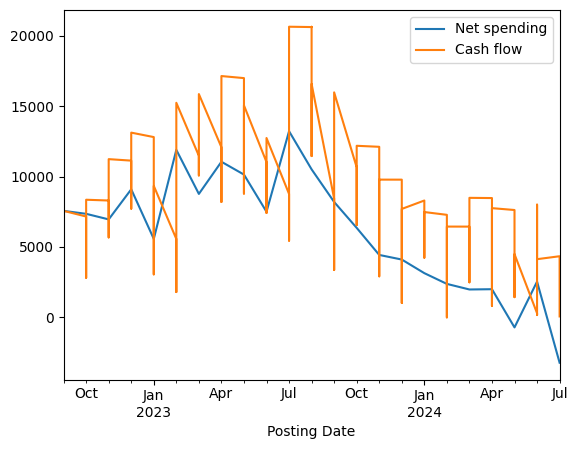

In [179]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum()).plot()
(START_BALANCE + checking_df.groupby("Posting Date").Amount.sum().cumsum()).plot()
plt.legend(["Net spending", "Cash flow"])